importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
import warnings
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
warnings.filterwarnings("ignore")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loading the dataset

In [ ]:
df=pd.read_csv('final_dataset.csv')

dropping the index columns

In [ ]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
df.head()

,Danceability,Energy,Loudness,Speechiness,Acousticness,Mode,Instrumentalness,Liveness,Valence,Tempo,Genre,Top100
0,0.556,0.864,-5.870,0.0584,0.009580,0,0.000000,0.209,0.400,105.143,5,0
1,0.737,0.463,-7.828,0.0792,0.008170,1,0.447000,0.255,0.324,123.881,9,0
2,0.618,0.938,-3.442,0.0456,0.017900,1,0.000000,0.167,0.875,91.455,9,0
3,0.331,0.943,-3.188,0.0698,0.007210,0,0.000002,0.242,0.296,94.612,0,0
4,0.589,0.890,-3.719,0.0603,0.000481,0,0.000820,0.201,0.692,90.598,5,0


transforming columns into a normal distribution

In [ ]:
from scipy import stats
df['Liveness']=np.log(df['Liveness'])
df['Speechiness']=stats.boxcox(df['Speechiness'])[0]
df['Acousticness']=stats.boxcox(df['Acousticness'])[0]

splitting dataset into features and label

In [ ]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

Balancing the dataset

In [ ]:
counter=Counter(y)
print('before',counter)
smt=SMOTETomek()
balanced_x,balanced_y=smt.fit_sample(x,y)
counter=Counter(balanced_y)
print('after',counter)

before Counter({0: 7151, 1: 1501})
after Counter({0: 7074, 1: 7074})


splitting data into training and testing sets

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(balanced_x,balanced_y,test_size=0.2)

Scaling the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
scaler=StandardScaler()


In [ ]:
scaled_x_train=scaler.fit_transform(x_train)
scaled_x_test=scaler.transform(x_test)

balancing the dataset using smote hybrid

#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

In [ ]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dt,
#                    feature_names=x.columns,
#                    class_names=['Non Hit', "Hit"],
#                    filled=True)

In [ ]:
## Model training by using default max_leaf_nodes=None
Model=DecisionTreeClassifier()
Model.fit(scaled_x_train,y_train)
pred=Model.predict(scaled_x_test)
acc=accuracy_score(y_test,pred)
print(acc)

0.8030356512530886


In [ ]:
## Hyper parameter tuning using randomized search cross validation
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


hypertuning decision tree classifier

In [ ]:

param_dist={"criterion":["gini","entropy"],"max_depth":[1,2,3,4,5,6,7,8,9,10,11]}
grid=RandomizedSearchCV(DecisionTreeClassifier(),param_distributions=param_dist,cv=5,n_jobs=-1)
grid.fit(scaled_x_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [ ]:
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
grid.best_score_

0.7593787420920449

In [ ]:
final_model=grid.best_estimator_

In [ ]:
y_pred=final_model.predict(scaled_x_test)

In [ ]:
print('confusion matrix')
print(confusion_matrix(y_test,y_pred))


confusion matrix
[[1039  356]
 [ 326 1112]]


In [ ]:
print('classification report')
print(classification_report(y_test,y_pred))

classification report
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1395
           1       0.76      0.77      0.77      1438

    accuracy                           0.76      2833
   macro avg       0.76      0.76      0.76      2833
weighted avg       0.76      0.76      0.76      2833



In [ ]:
acc=accuracy_score(y_test,y_pred)
print(acc)

0.7592657959759972


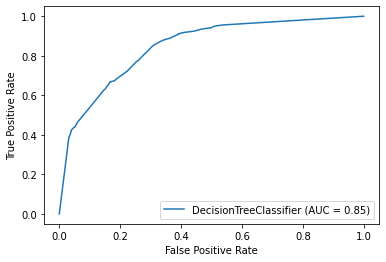

In [ ]:
#plotting ROC curve
import matplotlib.pyplot as plt
from sklearn import metrics
metrics.plot_roc_curve(final_model,scaled_x_test,y_test)
plt.show()



In [ ]:
from sklearn.externals import joblib
joblib.dump(final_model, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

#Ada boost classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
boost=AdaBoostClassifier(base_estimator=final_model)
boost.fit(scaled_x_train,y_train)
y_predict=boost.predict(scaled_x_test)

score:  <bound method ClassifierMixin.score of AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=11,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         

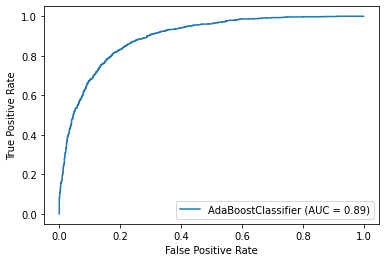

In [ ]:
#plotting ROC curve
print('score: ', boost.score)
print()
from sklearn import metrics
metrics.plot_roc_curve(boost,scaled_x_test,y_test)
plt.show()



In [ ]:
print('classification report')
print(classification_report(y_test,y_predict))

classification report
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1395
           1       0.81      0.84      0.82      1438

    accuracy                           0.82      2833
   macro avg       0.82      0.82      0.82      2833
weighted avg       0.82      0.82      0.82      2833



In [ ]:
print(confusion_matrix(y_test,y_predict))

[[1104  291]
 [ 228 1210]]


hypertunning ada boost

In [ ]:

param_dist={'n_estimators':[40,50,60,70,80], 'learning_rate':[0.04,0.03,0.02,0.1],'algorithm':['SAMME', 'SAMME.R']}
grid_1=RandomizedSearchCV(boost,param_distributions=param_dist,cv=5,n_jobs=-1)
grid_1.fit(scaled_x_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=11,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                           

score:  0.8484412828860846

ROC-AUC curve


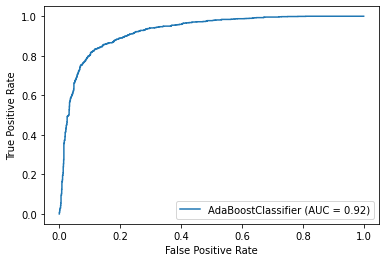

In [ ]:
#plotting ROC curve
print('score: ', grid_1.best_score_)
print()
print('ROC-AUC curve')
from sklearn import metrics
metrics.plot_roc_curve(boosted_model,scaled_x_test,y_test)
plt.show()



In [ ]:
predict=grid_1.predict(scaled_x_test)

In [ ]:
accuracy_score(y_test, predict)

0.8570420049417579

In [ ]:
print('classification report')
print(classification_report(y,pipeline.predict(x)))

classification report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7151
           1       0.83      0.89      0.86      1501

    accuracy                           0.95      8652
   macro avg       0.90      0.93      0.91      8652
weighted avg       0.95      0.95      0.95      8652



In [ ]:
boosted_model=grid_1.best_estimator_

In [ ]:
grid_1.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.02, 'n_estimators': 60}

In [ ]:
print('confusion_matrix')
print(confusion_matrix(y_test,predict))

confusion_matrix
[[1227  168]
 [ 237 1201]]


creating pipeline using standrd scaler and ada boost classifier

In [ ]:
from sklearn.pipeline import Pipeline
pipeline=Pipeline([('scaler', StandardScaler()), ('model', boosted_model)])
pipeline.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                          class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=11,
                                                                          max_features=None,
                                                                          max_leaf_nodes=None,
                                                                          min_impurity_decrease=0.0,
                                                                          min_impurity_split=None,
                                          

In [ ]:
pipeline.predict(x_test)

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [ ]:
joblib.dump(boosted_model, 'decision_tree_boosted.pkl')

['decision_tree_boosted.pkl']

#LDA

In [ ]:
lda=LinearDiscriminantAnalysis()
lda.fit(scaled_x_train,y_train)
y_pred=lda.predict(scaled_x_test)
print(accuracy_score(y_test,y_pred))

0.6544039617969579


hyper tuning lda

In [ ]:
parameters={'solver':['svd', 'lsqr', 'eigen'],'shrinkage':['auto','None']}
grid=GridSearchCV(LinearDiscriminantAnalysis(store_covariance=True),param_grid=parameters,cv=5,n_jobs=-1)
grid.fit(scaled_x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=True,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=-1,
             param_grid={'shrinkage': ['auto', 'None'],
                         'solver': ['svd', 'lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid.best_params_

{'shrinkage': 'auto', 'solver': 'lsqr'}

In [ ]:
grid.best_score_

0.6496859249074474

In [ ]:
lda_model=grid.best_estimator_

In [ ]:
y_pred=lda.predict(scaled_x_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62      1396
           1       0.64      0.74      0.68      1431

    accuracy                           0.65      2827
   macro avg       0.66      0.65      0.65      2827
weighted avg       0.66      0.65      0.65      2827



In [ ]:
print(confusion_matrix(y_test,y_pred))

[[ 794  602]
 [ 375 1056]]


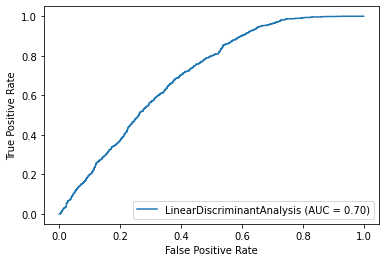

In [ ]:
#Plotting ROC curve for LDA
metrics.plot_roc_curve(lda_model,scaled_x_test,y_test)
plt.show()

In [ ]:
from sklearn.externals import joblib
joblib.dump(lda_model, 'LDA.pkl')